<Axes: xlabel='value', ylabel='Count'>

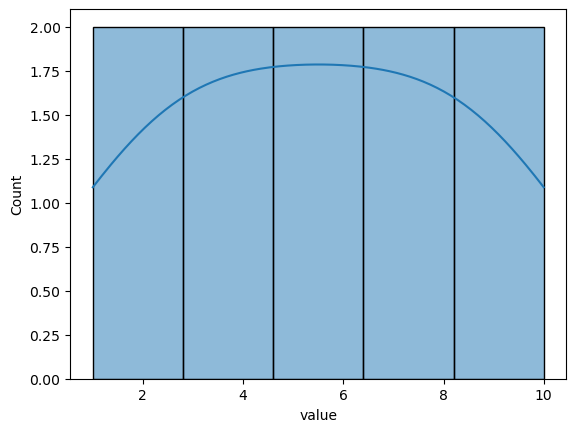

In [4]:
import seaborn as sns
import pandas as pd

# 创建一个示例 DataFrame
data = {'value': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
df = pd.DataFrame(data)

# 使用 seaborn 创建直方图
sns.histplot(data=df, x='value', kde=True)  # 使用 kde=True 添加密度曲线


KeyError: 'returns'

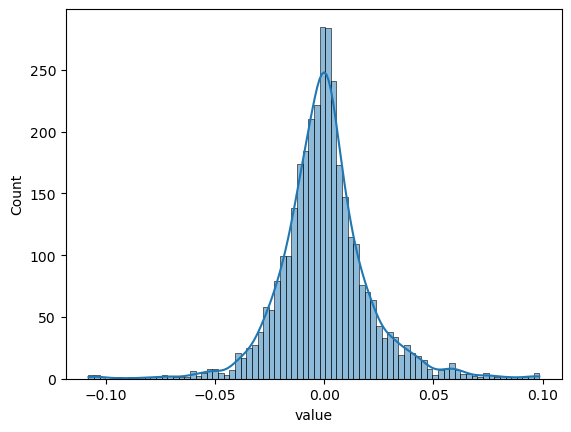

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import re,os
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math

# torch.autograd.set_detect_anomaly(True)
feature_columns = ['volume','amplitude','returns']

FEATURE_KS = 30
PREDICT_KS = 5

# 定义数据集类
class StockDataset(Dataset):
    def __init__(self,X,Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx],self.Y[idx]

class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens in the sequence.
        The positional encodings have the same dimension as the embeddings, so that the two can be summed.
        Here, we use sine and cosine functions of different frequencies.
    .. math:
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerModel(nn.Module):
    def __init__(self,input_size,seq_len):
        super(TransformerModel, self).__init__()
        d_model = 128
        self.seq_len = seq_len
        self.fc1 = nn.Linear(input_size,d_model,dtype=float,bias=False)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))  # 添加一个可学习的CLS头
        # self.pos_embedding = PositionalEncoding(d_model,max_len=120)
        self.pos_embedding = nn.Parameter(torch.randn(1, seq_len + 1, d_model))
        
        self.encoder_layer =  nn.TransformerEncoderLayer(d_model=d_model,dtype=float,nhead=4,activation='gelu',batch_first=True,bias=False)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        # self.transformer = nn.Transformer(d_model=d_model,dtype=float,dim_feedforward=256,activation='gelu',nhead=4,batch_first=True)
        self.fc = nn.Linear(d_model, 1,dtype=float,bias=False)
    
    def forward(self, x):
        x = self.fc1(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_token, x), dim=1)  # 将CLS头添加到输入序列的开头
        x += self.pos_embedding[:, :(self.seq_len + 1)]
        x = self.transformer_encoder(x)
        x = self.fc(x[:, 0, :])  # 只使用CLS头的输出进行预测
        return x

def data_preprocess(file_path):
    with open(file_path, 'r',errors="ignore") as file:
        lines = file.readlines()
    match = re.search(r'#(\d+)\.', file_path)
    code = match.group(1)
    lines = lines[2:-1]
    out_path = os.path.join("data",f'{code}.csv')
    with open(out_path, 'w') as file:
        file.writelines(lines)


def normilize(df):
    for col in feature_columns:
        df.loc[:,col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

    df.loc[:,'returns_5d'] = (df['returns_5d'] - df['returns_5d'].min()) / (df['returns_5d'].max() - df['returns_5d'].min())
    # print(df)
    X = []
    Y = []
    for i in range(len(df) - PREDICT_KS - FEATURE_KS):
        X.append(df[feature_columns].iloc[i:i + FEATURE_KS].values)
        Y.append(df['returns_5d'].iloc[i + FEATURE_KS])
    return np.array(X),np.array(Y)
    
    
def load_csv(file_path):
    df = pd.read_csv(file_path)
    df.columns = ['datetime','open','high','low','close','volume','amount']
    df.set_index('datetime', inplace=True)
    df.index = pd.to_datetime(df.index)
    df = df['2010':]
    df = df[['open','high','low','close','volume']]
    df = df.astype(float)

    # df['change'] = df['close'].pct_change()

    df['amplitude'] = ((df['high'] - df['low']) / df['close'].shift(1))
    df['returns'] = np.log(df['close'] / df['close'].shift(1))
    df['value'] = (df['close'].shift(-PREDICT_KS) - df['close']) / df['close']

    df.dropna(inplace=True)

    # df['volume_norm'] = (df['volume'] - df['volume'].min()) / (df['volume'].max() - df['volume'].min())
    sns.histplot(data=df, x='value', kde=True)  # 使用 kde=True 添加密度曲线

    train_size = int(len(df) * 0.8)
    train_set,test_set = df.iloc[:train_size],df.iloc[train_size:]
    return normilize(train_set),normilize(test_set)
(train_X,train_Y),(test_X,test_Y) = load_csv('data/000001.csv')